# Movie Trailer Shot Detection Notebook

This notebook implements shot boundary detection in movie trailers. It demonstrates:
- Loading and processing video frames
- Detecting shot transitions using histogram differences
- Visualizing shot boundaries and keyframes
- Saving representative frames from each shot

This analysis helps understand the editing rhythm and visual structure of movie trailers.

## 1. Setup and Dependencies

First, let's import the necessary libraries for video processing and analysis.

In [1]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import time
from tqdm import tqdm
import pandas as pd
from IPython.display import Image, display

# Configure matplotlib for better display in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

# Create output directory for shot keyframes
os.makedirs('outputs/shots', exist_ok=True)


## 2. Load Video File

We'll load the movie trailer and extract basic information about it.

In [2]:
# Define the path to the video file
video_path = 'data/sample_trailer.mp4'

# Check if video file exists
if not os.path.exists(video_path):
    print(f"Error: Video file '{video_path}' not found")
    print("Please place a sample trailer video in the data directory")
else:
    # Load the video using OpenCV for frame processing
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps
    
    print("Video Metadata:")
    print(f"Resolution: {width}x{height}")
    print(f"FPS: {fps:.2f}")
    print(f"Frame count: {frame_count}")
    print(f"Duration: {duration:.2f} seconds")
    
    # Also load with MoviePy for easier timestamp handling
    clip = VideoFileClip(video_path)
    print(f"Loaded video: {video_path}")


Video Metadata:
Resolution: 1280x720
FPS: 23.98
Frame count: 3296
Duration: 137.47 seconds
Loaded video: data/sample_trailer.mp4


## 3. Shot Boundary Detection

We'll implement a histogram-based shot boundary detection algorithm. This method works by:
1. Computing color histograms for each frame
2. Measuring the difference between consecutive frames' histograms
3. When the difference exceeds a threshold, we consider it a shot boundary

This is a simple but effective approach for detecting hard cuts between shots.

In [3]:
# Function to compute frame histogram
def compute_frame_histogram(frame):
    """Compute color histogram for the frame."""
    # Convert the frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Calculate histogram for hue and saturation channels
    hist = cv2.calcHist([hsv], [0, 1], None, [32, 32], [0, 180, 0, 256])
    
    # Normalize the histogram
    cv2.normalize(hist, hist, 0, 1.0, cv2.NORM_MINMAX)
    return hist

# Function to calculate histogram difference
def histogram_difference(hist1, hist2):
    """Calculate difference between two histograms."""
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)


In [4]:
# Initialize variables for shot detection
shot_boundaries = []
prev_hist = None
threshold = 0.5  # Threshold for shot boundary detection
min_shot_length = int(fps / 2)  # Minimum shot length (0.5 second)
last_boundary = -min_shot_length  # To prevent detecting shots that are too close

# Process each frame to detect shot boundaries
print("Detecting shot boundaries...")
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the first frame

# Store frames and differences for visualization
frame_diffs = []
keyframes = []

# Use tqdm for progress tracking
for frame_idx in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break
    
    # Compute histogram
    hist = compute_frame_histogram(frame)
    
    if prev_hist is not None:
        # Calculate difference with previous frame
        diff = histogram_difference(hist, prev_hist)
        frame_diffs.append(diff)
        
        # Check if this is a shot boundary
        if diff > threshold and (frame_idx - last_boundary) > min_shot_length:
            timestamp = frame_idx / fps
            shot_boundaries.append((frame_idx, timestamp))
            keyframes.append((frame_idx, frame.copy()))
            last_boundary = frame_idx
    
    # Update for next iteration
    prev_hist = hist

# Add the last frame as the end of the last shot
if frame_count > 0:
    shot_boundaries.append((frame_count-1, (frame_count-1) / fps))

print(f"Detected {len(shot_boundaries)-1} shot boundaries")

# Release OpenCV video capture
cap.release()


Detecting shot boundaries...


100%|█████████████████████████| 3296/3296 [00:21<00:00, 152.86it/s]

Detected 92 shot boundaries


## 4. Visualize Shot Boundaries

Now we'll visualize the detected shot boundaries and the histogram differences between frames.

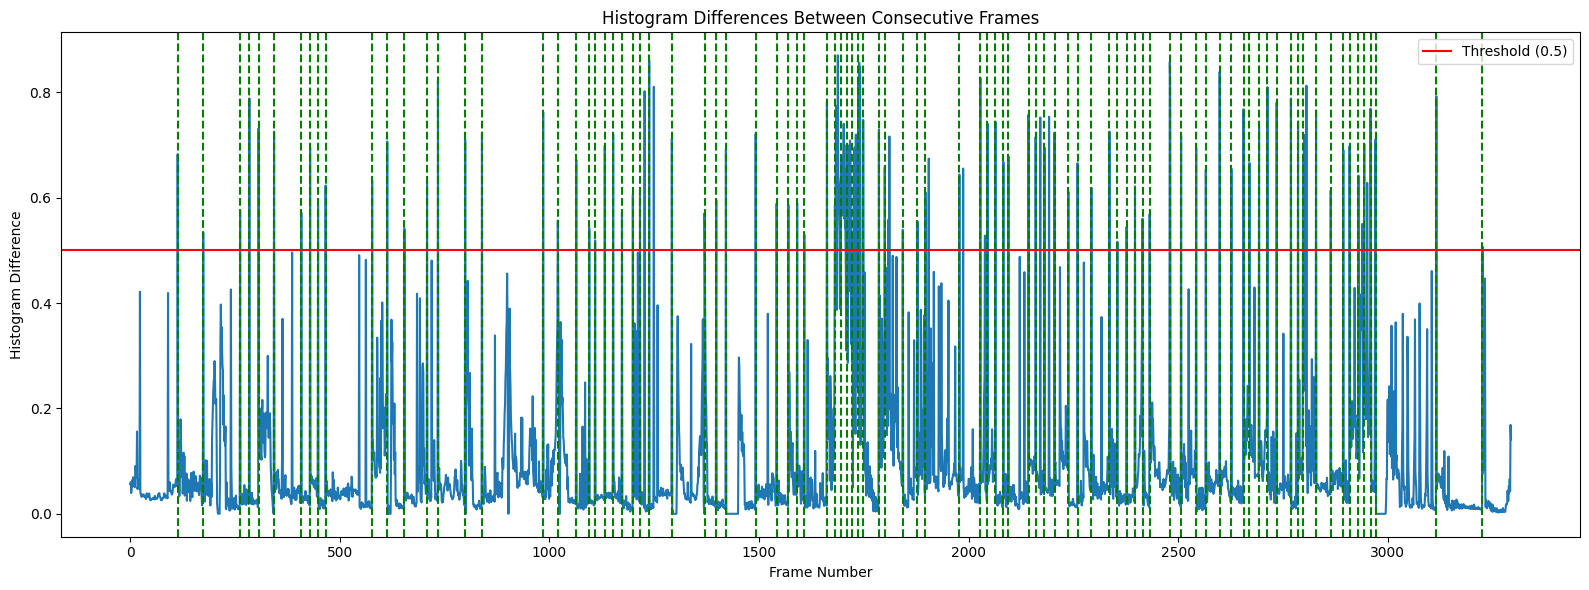

In [5]:
# Plot histogram differences across frames
plt.figure(figsize=(16, 6))
plt.plot(frame_diffs)
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold ({threshold})')

# Mark shot boundaries on the plot
for idx, timestamp in shot_boundaries[:-1]:
    plt.axvline(x=idx-1, color='g', linestyle='--')

plt.title('Histogram Differences Between Consecutive Frames')
plt.xlabel('Frame Number')
plt.ylabel('Histogram Difference')
plt.legend()
plt.tight_layout()
plt.show()


## 5. Extract Shot Information

For each detected shot, we'll extract its start and end timestamps and save a representative keyframe.

In [6]:
# Create a list of shot segments with start and end timestamps
shot_segments = []
for i in range(len(shot_boundaries) - 1):
    start_idx, start_time = shot_boundaries[i]
    end_idx, end_time = shot_boundaries[i+1]
    duration = end_time - start_time
    shot_segments.append({
        'shot_id': i+1,
        'start_frame': start_idx,
        'end_frame': end_idx,
        'start_time': start_time,
        'end_time': end_time,
        'duration': duration
    })

# Create a DataFrame for better visualization
shots_df = pd.DataFrame(shot_segments)
print(f"Found {len(shots_df)} shots")
shots_df.head()


Found 92 shots


,shot_id,start_frame,end_frame,start_time,end_time,duration
0,1,114,175,4.754750,7.298958,2.544208
1,2,175,263,7.298958,10.969292,3.670333
2,3,263,285,10.969292,11.886875,0.917583
3,4,285,307,11.886875,12.804458,0.917583
4,5,307,344,12.804458,14.347667,1.543208


Saving keyframes for each shot...
Shot 1/92: Frame 114 saved to outputs/shots/shot_001_frame_00114.jpg
Shot 2/92: Frame 175 saved to outputs/shots/shot_002_frame_00175.jpg
Shot 3/92: Frame 263 saved to outputs/shots/shot_003_frame_00263.jpg
Shot 4/92: Frame 285 saved to outputs/shots/shot_004_frame_00285.jpg
Shot 5/92: Frame 307 saved to outputs/shots/shot_005_frame_00307.jpg
Shot 6/92: Frame 344 saved to outputs/shots/shot_006_frame_00344.jpg
Shot 7/92: Frame 409 saved to outputs/shots/shot_007_frame_00409.jpg
Shot 8/92: Frame 430 saved to outputs/shots/shot_008_frame_00430.jpg
Shot 9/92: Frame 449 saved to outputs/shots/shot_009_frame_00449.jpg
Shot 10/92: Frame 467 saved to outputs/shots/shot_010_frame_00467.jpg
Shot 11/92: Frame 578 saved to outputs/shots/shot_011_frame_00578.jpg
Shot 12/92: Frame 614 saved to outputs/shots/shot_012_frame_00614.jpg
Shot 13/92: Frame 655 saved to outputs/shots/shot_013_frame_00655.jpg
Shot 14/92: Frame 709 saved to outputs/shots/shot_014_frame_00709

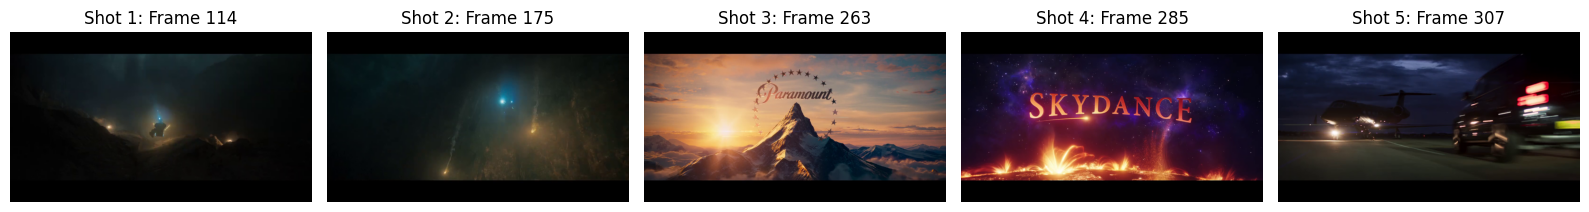

In [7]:
# Save representative keyframes for each shot
print("Saving keyframes for each shot...")

for shot_idx, (frame_idx, frame) in enumerate(keyframes):
    # Convert from BGR to RGB for displaying and saving
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Save the keyframe
    output_path = f'outputs/shots/shot_{shot_idx+1:03d}_frame_{frame_idx:05d}.jpg'
    plt.imsave(output_path, rgb_frame)
    
    print(f"Shot {shot_idx+1}/{len(keyframes)}: Frame {frame_idx} saved to {output_path}")

# Display some sample keyframes
num_samples = min(5, len(keyframes))
plt.figure(figsize=(16, 12))

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    frame_idx = keyframes[i][0]
    rgb_frame = cv2.cvtColor(keyframes[i][1], cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.title(f'Shot {i+1}: Frame {frame_idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## 6. Visualize Shot Timeline

Let's create a visual representation of the shots and their durations to understand the editing rhythm.

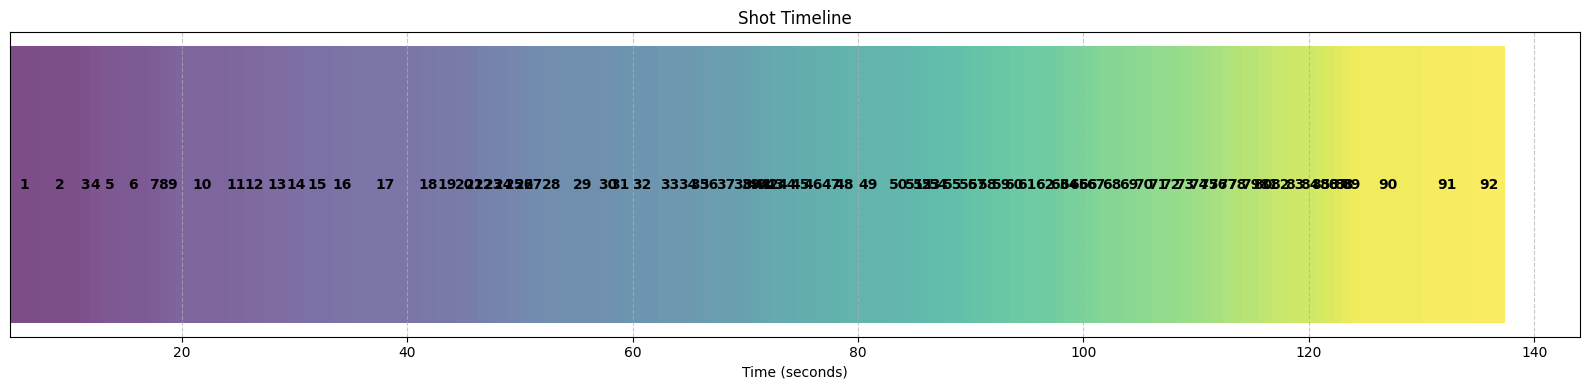

Shot Summary:
Total number of shots: 92
Average shot duration: 1.44 seconds
Shortest shot: 0.50 seconds
Longest shot: 6.09 seconds
Shots per minute: 41.61


In [8]:
# Create a visual timeline of shots
plt.figure(figsize=(16, 4))

# Plot horizontal bars for each shot
for i, shot in enumerate(shot_segments):
    start = shot['start_time']
    duration = shot['duration']
    plt.barh(y=0, width=duration, left=start, height=0.5, 
             color=plt.cm.viridis(i / len(shot_segments)), 
             alpha=0.7)
    
    # Add shot numbers at the middle of each bar
    if duration > 0.5:  # Only label shots with sufficient duration
        plt.text(start + duration/2, 0, f"{i+1}", 
                 ha='center', va='center', fontweight='bold')

plt.title('Shot Timeline')
plt.xlabel('Time (seconds)')
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print a summary of the shots
print("Shot Summary:")
total_duration = sum(shot['duration'] for shot in shot_segments)
avg_shot_duration = total_duration / len(shot_segments) if shot_segments else 0

print(f"Total number of shots: {len(shot_segments)}")
print(f"Average shot duration: {avg_shot_duration:.2f} seconds")
print(f"Shortest shot: {min([s['duration'] for s in shot_segments]):.2f} seconds")
print(f"Longest shot: {max([s['duration'] for s in shot_segments]):.2f} seconds")
print(f"Shots per minute: {len(shot_segments) / (total_duration / 60):.2f}")


## 7. Advanced Analysis (Future Improvements)

This notebook demonstrates a basic shot boundary detection approach using histogram differences. 
For future improvements, consider:

1. **Deep Learning-Based Detection**: Using convolutional neural networks for more accurate shot boundary detection
2. **Transition Type Classification**: Detecting different types of transitions (cuts, fades, dissolves, wipes)
3. **Content Analysis**: Analyzing the content within each shot (faces, objects, text)
4. **Audio-Visual Correlation**: Correlating shot changes with audio cues
5. **Shot Clustering**: Grouping similar shots to identify repeated visual motifs
6. **Scene Detection**: Grouping related shots into coherent scenes

These advanced techniques could provide deeper insights into trailer editing patterns and storytelling techniques.

In [9]:
# Cleanup resources
clip.close()

print("Analysis complete!")


Analysis complete!
